In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"debeshkumar04","key":"805faf0ad81376aeebe7900e3184b77b"}'}

In [8]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!pip install -q kaggle

In [10]:
!kaggle datasets download -d datasnaek/mbti-type

Dataset URL: https://www.kaggle.com/datasets/datasnaek/mbti-type
License(s): CC0-1.0
mbti-type.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
!unzip mbti-type.zip -d ./data

Archive:  mbti-type.zip
replace ./data/mbti_1.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./data/mbti_1.csv       


In [12]:
from google.colab import files
uploaded = files.upload()

Saving glove.6B.100d.txt to glove.6B.100d.txt


In [13]:
import pandas as pd

df = pd.read_csv("data/mbti_1.csv")
df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [14]:
from sklearn.model_selection import train_test_split
import re

def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.lower()
    return text

df['clean_text'] = df['posts'].apply(clean_text)

df['IE'] = df['type'].apply(lambda x: 1 if x[0] == 'I' else 0)
df['NS'] = df['type'].apply(lambda x: 1 if x[1] == 'N' else 0)
df['TF'] = df['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
df['JP'] = df['type'].apply(lambda x: 1 if x[3] == 'J' else 0)

X = df['clean_text'].values
y1 = df['IE'].values
y2 = df['NS'].values
y3 = df['TF'].values
y4 = df['JP'].values

X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, stratify=y1, random_state=42)
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, stratify=y2, random_state=42)
X_train, X_test, y3_train, y3_test = train_test_split(X, y3, test_size=0.2, stratify=y3, random_state=42)
X_train, X_test, y4_train, y4_test = train_test_split(X, y4, test_size=0.2, stratify=y4, random_state=42)

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

maxlen = 300
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')

word_index = tokenizer.word_index

In [16]:
import numpy as np

embedding_index = {}
with open("/content/glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

print(f"{len(embedding_index)} words loaded from GloVe.")

embedding_dim = 100
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

400000 words loaded from GloVe.


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=maxlen,
              trainable=False),  # Freeze GloVe
    Conv1D(128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    26,254,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,254,600 (100.15 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 26,254,600 (100.15 MB)

Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 50s 250ms/step - accuracy: 0.7355 - loss: 0.5902 - val_accuracy: 0.7723 - val_loss: 0.5378 - learning_rate: 0.0010
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 79s 235ms/step - accuracy: 0.7711 - loss: 0.5500 - val_accuracy: 0.7723 - val_loss: 0.5379 - learning_rate: 0.0010
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.7700 - loss: 0.5432
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
174/174 ━━━━━━━━━━━━━━━━━━━━ 45s 257ms/step - accuracy: 0.7700 - loss: 0.5432 - val_accuracy: 0.7723 - val_loss: 0.5427 - learning_rate: 0.0010
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 78s 234ms/step - accuracy: 0.7743 - loss: 0.5336 - val_accuracy: 0.7723 - val_loss: 0.5466 - learning_rate: 5.0000e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       400
           1       0.77      1.00      0.87      1335

    accuracy       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


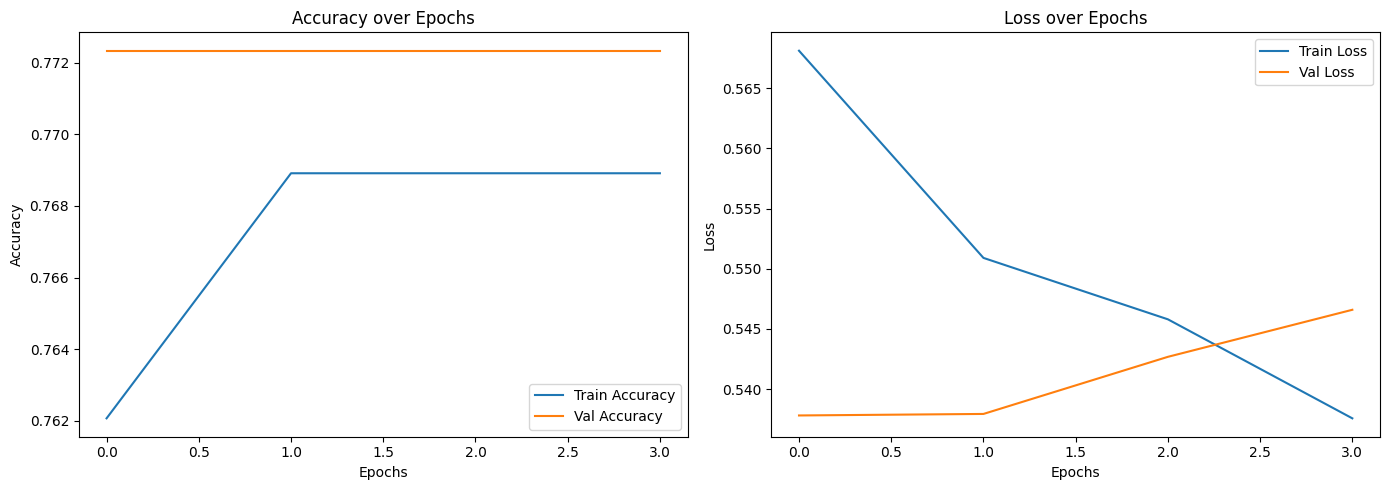

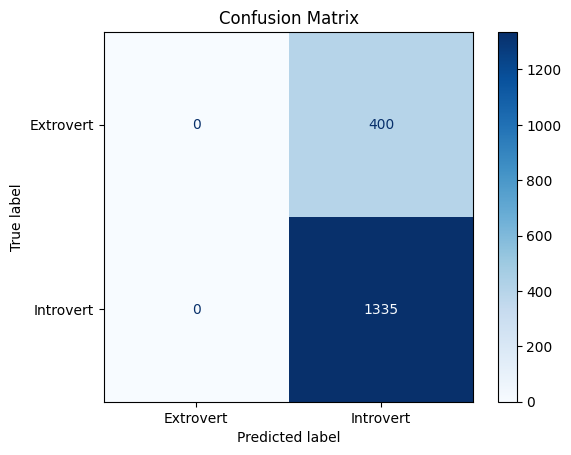

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step


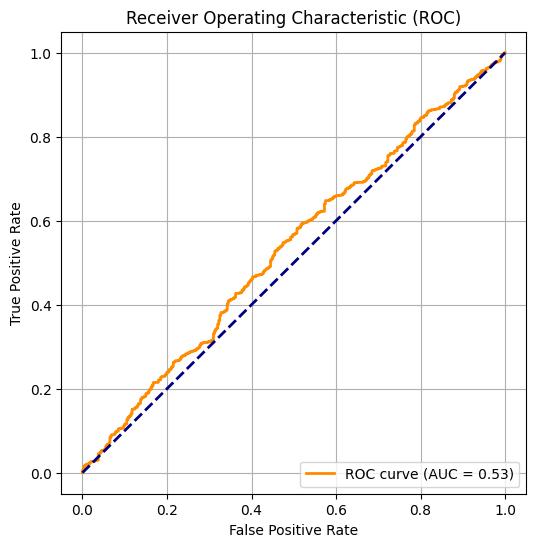

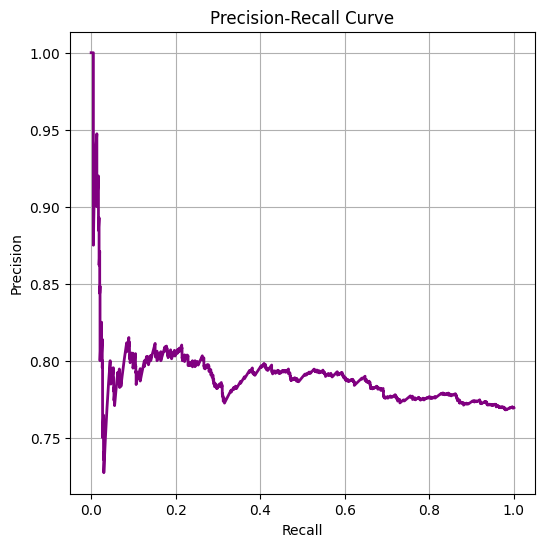

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

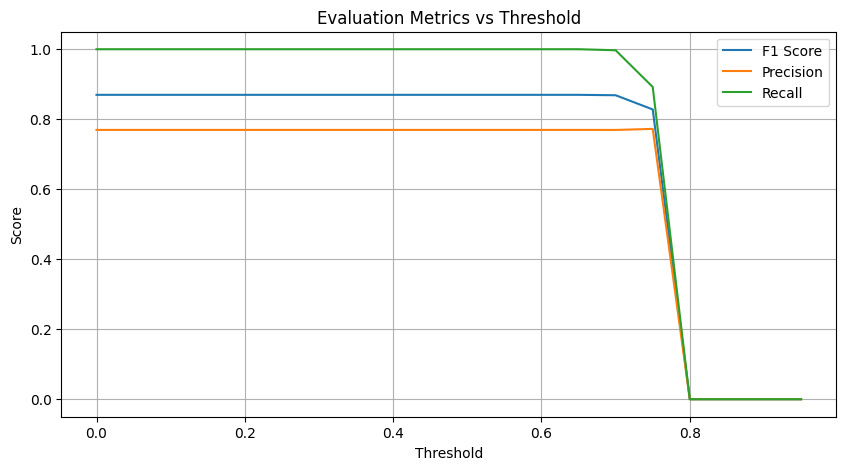

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1)
]

history = model.fit(X_train_pad, y1_train,
                    validation_split=0.2,
                    epochs=10,
                    batch_size=32,
                    callbacks=callbacks)

from sklearn.metrics import classification_report, accuracy_score

y1_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
print(classification_report(y1_test, y1_pred))
print("Accuracy:", accuracy_score(y1_test, y1_pred))

import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y1_test, y1_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Extrovert", "Introvert"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import roc_curve, auc

y1_proba = model.predict(X_test_pad).ravel()
fpr, tpr, thresholds = roc_curve(y1_test, y1_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y1_test, y1_proba)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

thresholds = np.arange(0.0, 1.0, 0.05)
f1s, precisions, recalls = [], [], []

for t in thresholds:
    pred = (y1_proba >= t).astype(int)
    f1s.append(f1_score(y1_test, pred))
    precisions.append(precision_score(y1_test, pred))
    recalls.append(recall_score(y1_test, pred))

plt.figure(figsize=(10,5))
plt.plot(thresholds, f1s, label='F1 Score')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Evaluation Metrics vs Threshold')
plt.legend()
plt.grid()
plt.show()

Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.8612 - loss: 0.4214 - val_accuracy: 0.8674 - val_loss: 0.3920 - learning_rate: 5.0000e-04
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 51s 292ms/step - accuracy: 0.8702 - loss: 0.4023 - val_accuracy: 0.8674 - val_loss: 0.4001 - learning_rate: 5.0000e-04
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8568 - loss: 0.4145
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
174/174 ━━━━━━━━━━━━━━━━━━━━ 75s 250ms/step - accuracy: 0.8568 - loss: 0.4145 - val_accuracy: 0.8674 - val_loss: 0.3936 - learning_rate: 5.0000e-04
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 80s 236ms/step - accuracy: 0.8578 - loss: 0.4128 - val_accuracy: 0.8674 - val_loss: 0.3963 - learning_rate: 2.5000e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       400
           1       0.77      1.00      0.87      1335

    accuracy                           0.77      1735
   macro avg       0.38      0.50      0.43      1735
weighted avg       0.59      0.77      0.67      1735

Accuracy: 0.7694524495677233


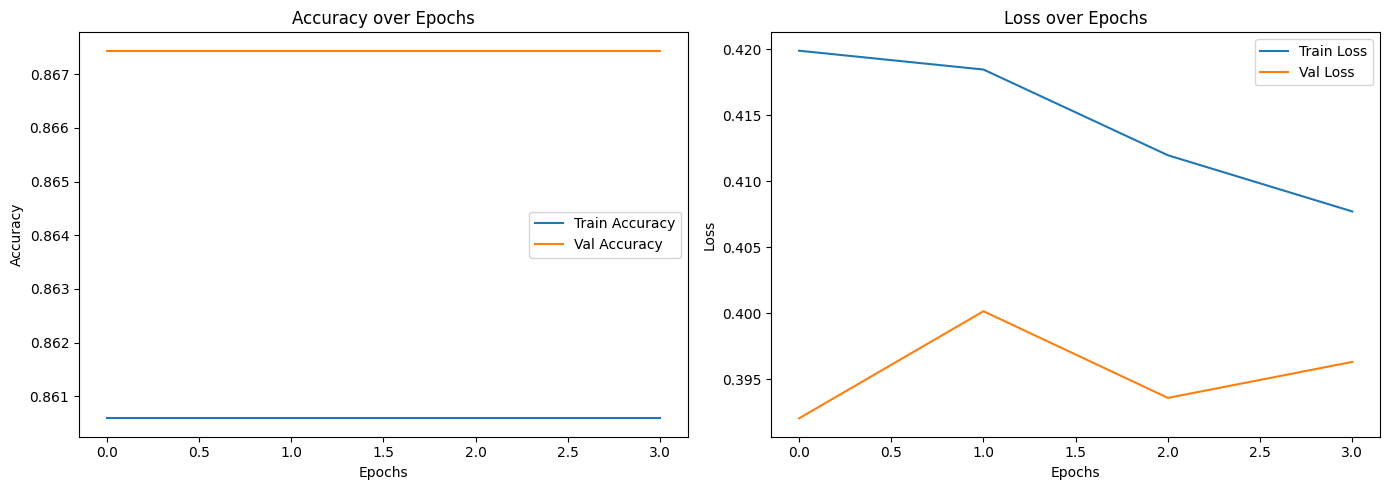

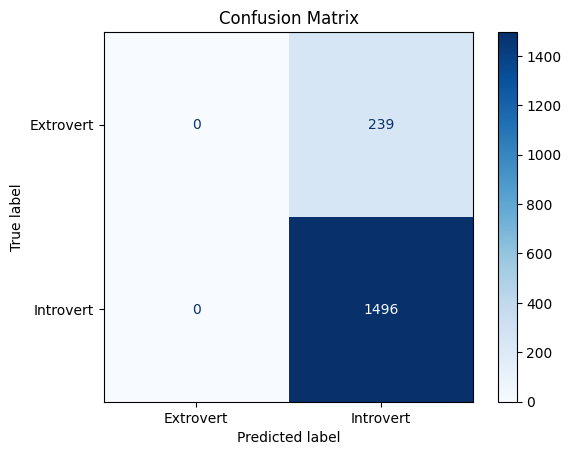

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step


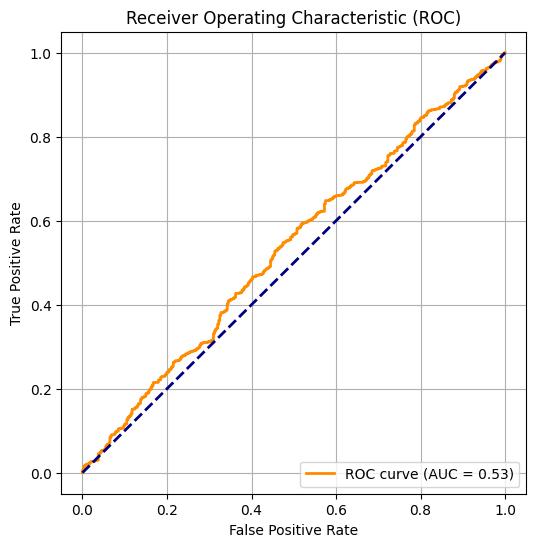

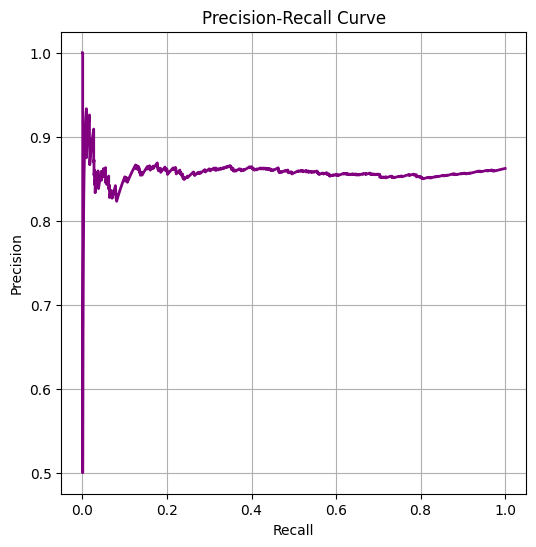

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


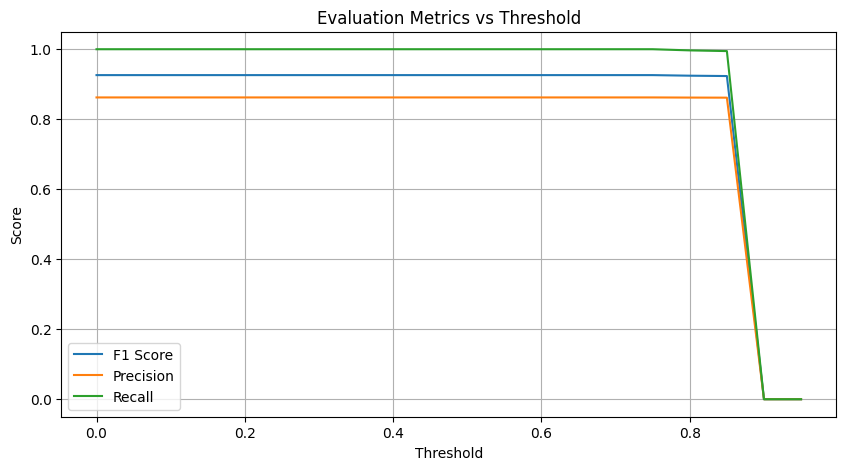

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1)
]

history = model.fit(X_train_pad, y2_train,
                    validation_split=0.2,
                    epochs=10,
                    batch_size=32,
                    callbacks=callbacks)

from sklearn.metrics import classification_report, accuracy_score

y2_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
print(classification_report(y1_test, y2_pred))
print("Accuracy:", accuracy_score(y1_test, y2_pred))

import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y2_test, y2_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Extrovert", "Introvert"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import roc_curve, auc

y2_proba = model.predict(X_test_pad).ravel()
fpr, tpr, thresholds = roc_curve(y1_test, y1_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y2_test, y2_proba)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

thresholds = np.arange(0.0, 1.0, 0.05)
f1s, precisions, recalls = [], [], []

for t in thresholds:
    pred = (y2_proba >= t).astype(int)
    f1s.append(f1_score(y2_test, pred))
    precisions.append(precision_score(y2_test, pred))
    recalls.append(recall_score(y2_test, pred))

plt.figure(figsize=(10,5))
plt.plot(thresholds, f1s, label='F1 Score')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Evaluation Metrics vs Threshold')
plt.legend()
plt.grid()
plt.show()

Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 41s 236ms/step - accuracy: 0.4850 - loss: 0.8009 - val_accuracy: 0.5382 - val_loss: 0.6899 - learning_rate: 2.5000e-04
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 44s 251ms/step - accuracy: 0.5426 - loss: 0.6935 - val_accuracy: 0.5432 - val_loss: 0.6916 - learning_rate: 2.5000e-04
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.5200 - loss: 0.6943
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
174/174 ━━━━━━━━━━━━━━━━━━━━ 81s 246ms/step - accuracy: 0.5200 - loss: 0.6943 - val_accuracy: 0.5418 - val_loss: 0.6901 - learning_rate: 2.5000e-04
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 80s 237ms/step - accuracy: 0.5409 - loss: 0.6899 - val_accuracy: 0.5403 - val_loss: 0.6911 - learning_rate: 1.2500e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step
              precision    recall  f1-score   support

           0       0.54      0.99      0.70       939
           1       0.25      0.00      0.01       796

    acc

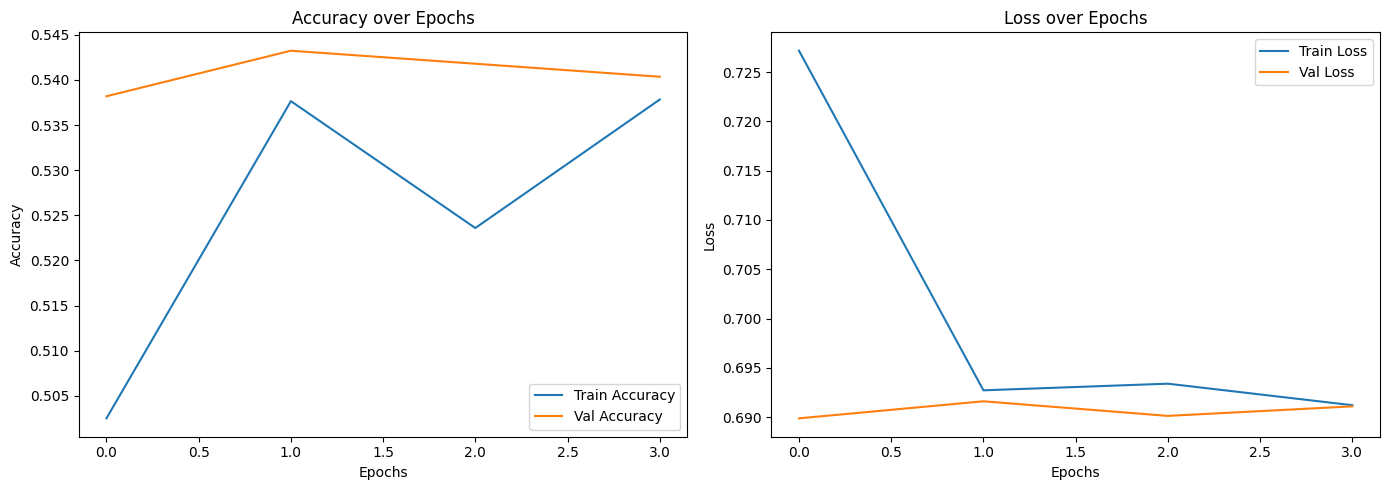

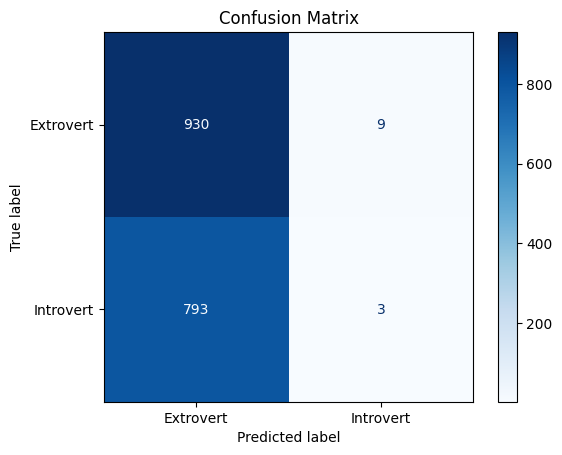

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step


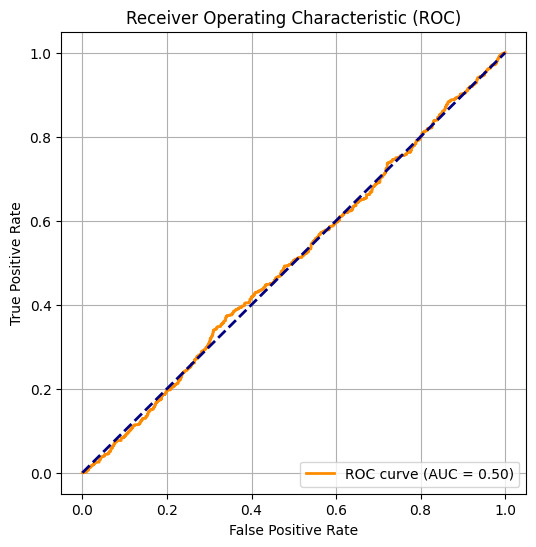

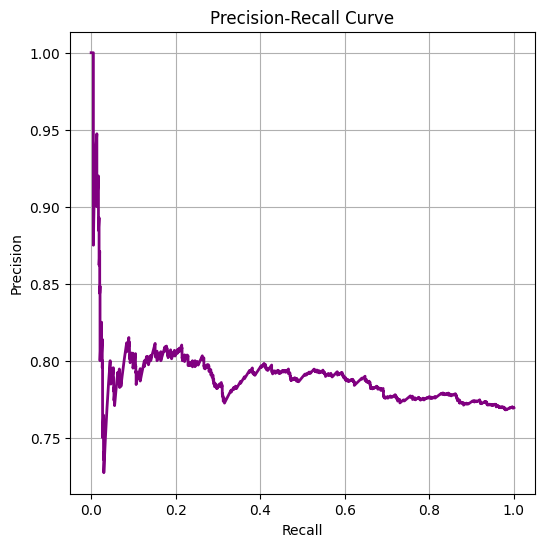

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

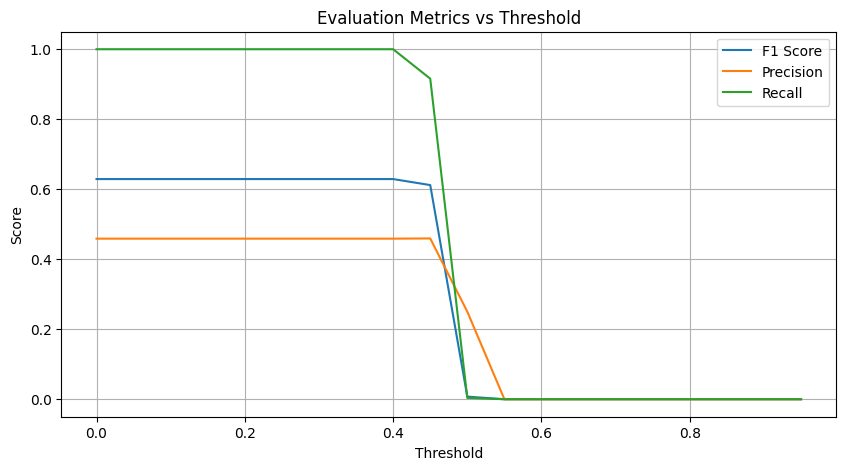

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1)
]

history = model.fit(X_train_pad, y3_train,
                    validation_split=0.2,
                    epochs=10,
                    batch_size=32,
                    callbacks=callbacks)

from sklearn.metrics import classification_report, accuracy_score

y3_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
print(classification_report(y3_test, y3_pred))
print("Accuracy:", accuracy_score(y3_test, y3_pred))

import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y3_test, y3_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Extrovert", "Introvert"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import roc_curve, auc

y3_proba = model.predict(X_test_pad).ravel()
fpr, tpr, thresholds = roc_curve(y3_test, y3_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y1_test, y1_proba)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

thresholds = np.arange(0.0, 1.0, 0.05)
f1s, precisions, recalls = [], [], []

for t in thresholds:
    pred = (y3_proba >= t).astype(int)
    f1s.append(f1_score(y3_test, pred))
    precisions.append(precision_score(y3_test, pred))
    recalls.append(recall_score(y3_test, pred))

plt.figure(figsize=(10,5))
plt.plot(thresholds, f1s, label='F1 Score')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Evaluation Metrics vs Threshold')
plt.legend()
plt.grid()
plt.show()

Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 41s 238ms/step - accuracy: 0.5642 - loss: 0.6824 - val_accuracy: 0.6009 - val_loss: 0.6730 - learning_rate: 1.2500e-04
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 42s 242ms/step - accuracy: 0.5962 - loss: 0.6765 - val_accuracy: 0.6009 - val_loss: 0.6747 - learning_rate: 1.2500e-04
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.6141 - loss: 0.6719
Epoch 3: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
174/174 ━━━━━━━━━━━━━━━━━━━━ 81s 237ms/step - accuracy: 0.6140 - loss: 0.6720 - val_accuracy: 0.6009 - val_loss: 0.6750 - learning_rate: 1.2500e-04
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 82s 239ms/step - accuracy: 0.6081 - loss: 0.6729 - val_accuracy: 0.6009 - val_loss: 0.6747 - learning_rate: 6.2500e-05
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.60      1.00      0.75      1048
           1       0.00      0.00      0.00       687

    accuracy                           0.60      1735
   macro avg       0.30      0.50      0.38      1735
weighted avg       0.36      0.60      0.45      1735

Accuracy: 0.6040345821325649


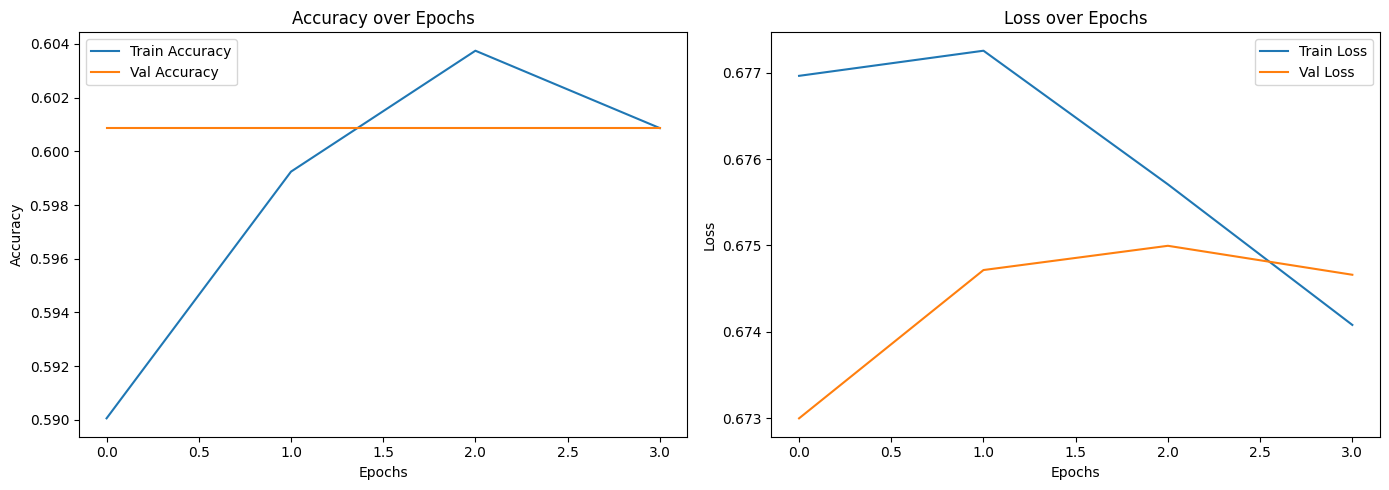

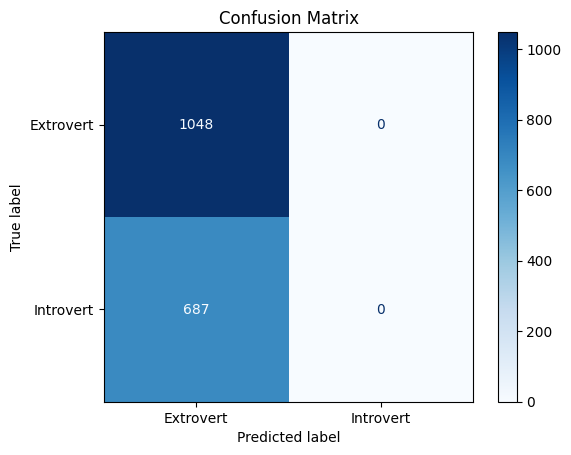

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step


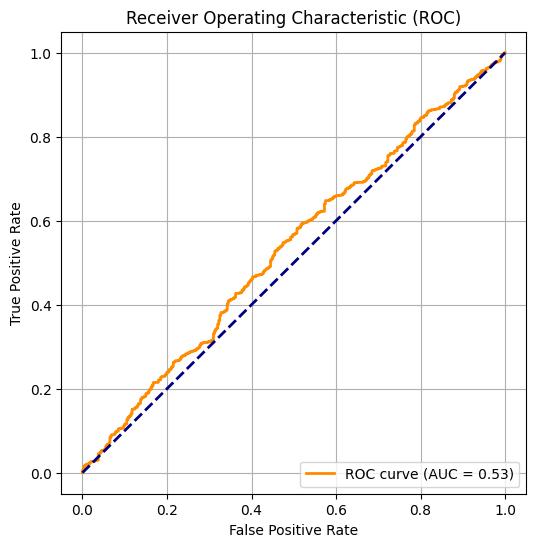

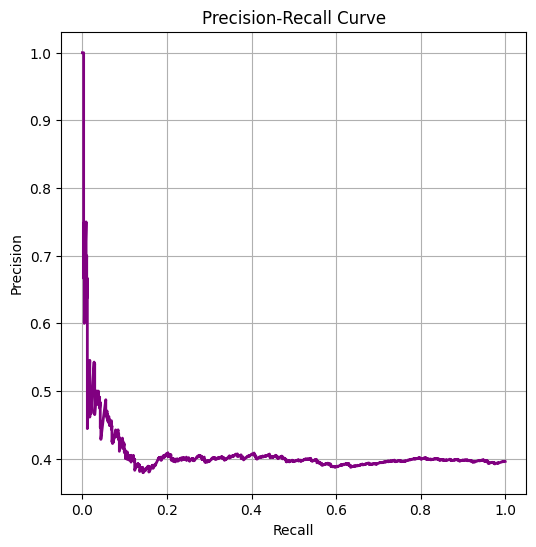

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

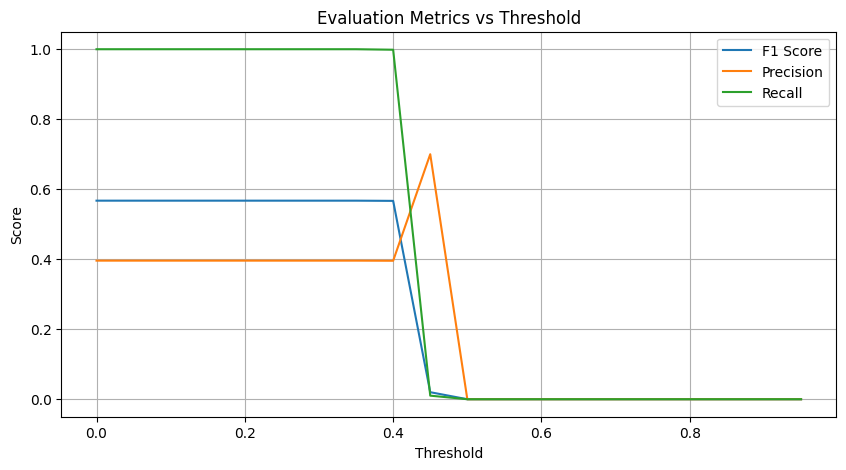

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1)
]

history = model.fit(X_train_pad, y4_train,
                    validation_split=0.2,
                    epochs=10,
                    batch_size=32,
                    callbacks=callbacks)

from sklearn.metrics import classification_report, accuracy_score

y4_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
print(classification_report(y4_test, y4_pred))
print("Accuracy:", accuracy_score(y4_test, y4_pred))

import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y4_test, y4_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Extrovert", "Introvert"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import roc_curve, auc

y4_proba = model.predict(X_test_pad).ravel()
fpr, tpr, thresholds = roc_curve(y1_test, y1_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y4_test, y4_proba)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

thresholds = np.arange(0.0, 1.0, 0.05)
f1s, precisions, recalls = [], [], []

for t in thresholds:
    pred = (y4_proba >= t).astype(int)
    f1s.append(f1_score(y4_test, pred))
    precisions.append(precision_score(y4_test, pred))
    recalls.append(recall_score(y4_test, pred))

plt.figure(figsize=(10,5))
plt.plot(thresholds, f1s, label='F1 Score')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Evaluation Metrics vs Threshold')
plt.legend()
plt.grid()
plt.show()